In [1]:
# importing packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# reading in CSV
df = pd.read_csv('creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
254969,157003.0,0.121685,0.990536,-0.449069,-0.555860,1.004292,-0.798871,0.955062,-0.105045,-0.048104,...,-0.343563,-0.852037,0.093501,0.474447,-0.401226,0.118758,0.220506,0.084387,4.99,0
120088,75706.0,-0.644431,0.616995,-0.034061,-1.542783,2.884229,3.102120,0.222305,0.897864,-0.643099,...,-0.239270,-1.000861,-0.075247,0.932284,-0.001419,-0.044064,0.037365,0.113453,9.21,0
69784,53581.0,1.083448,0.237004,0.547034,1.007855,-0.168149,-0.187504,0.038606,0.017704,-0.383930,...,0.066481,0.209556,-0.012882,0.235400,0.437695,-0.445046,0.037423,0.020770,29.94,0
127236,78257.0,-1.005030,1.085609,-0.287963,-1.313881,2.402693,3.304870,0.078386,0.918765,-0.063993,...,-0.341013,-0.936019,0.057978,0.973877,0.079936,0.087449,0.357701,0.234344,0.89,0
163403,115907.0,1.940847,-0.863129,-0.308239,0.667133,-1.108577,-0.229832,-0.905282,0.054437,-0.286118,...,0.062379,0.724249,0.060358,0.039766,-0.054572,-0.402665,0.062921,-0.034682,50.00,0


### Remove irrelevant features like time before training model

In [2]:
df = df.drop('Time', axis=1)

# Full code for machine learning pipeline
### Note: SCI17 Jupyter Notebook and sklearn_classification_pipeline.py has the more updated version
### Pipeline allows one to select variable list to use in model, to standardize data, ratio of data for testing in train-test
### Type of sampling - naive, smote, adasyn (with options to add more)
### Type of model
### Custom text for decision matrix shown as heatmap
### Whether to enable or disable CV (this is changed to a custom built stratified CV in SCI17 and py code)

In [3]:
# importing packages
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb 
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import math
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter

class modelpipeline:
    def __init__(self):
        pass
    
    def run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV):
        # Align field orders in df (including response)
        df = df[varlist]

        if sampletype == 'smote':
            X_train, X_test, y_train, y_test = sampling.smote_oversample(df, testratio, response)
        elif sampletype == 'adasyn':
            X_train, X_test, y_train, y_test = sampling.adasyn_oversample(df, testratio, response)
        else:
            X_train, X_test, y_train, y_test = sampling.naive_oversample(df, testratio, response)
            
        if standardize == True:
            scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
            X_train = scaling.transform(X_train)
            X_test = scaling.transform(X_test)
            
        store = self.build_model(X_train, X_test, y_train, y_test, text, modelname, CV)
        # test model with all actual fraud results
        store['actual_accuracy'] = evaluate.actual_acc(df, store['model'], response)
        return store
    
    def build_model(self, X_train, X_test, y_train, y_test, text, modelname, CV):
        if modelname == 'LogisticRegression':
            if CV == True:
                param_grid = dict(C=[0.8,1,1.2], max_iter=[300], solver=['liblinear'])
                LogRegression = LogisticRegression()
                model = GridSearchCV(LogRegression, param_grid, cv=5, scoring='f1', verbose=10)
                model.fit(X_train,y_train)
                print("Best f1 score: " + str(model.best_score_))
                print("Best parameters: " + str(model.best_params_))
            else:
                model = LogisticRegression(max_iter=300, C=0.8, solver='liblinear')
                model.fit(X_train,y_train)
        elif modelname == 'XGBoost':
            if CV == True:
                end_value = math.ceil(math.sqrt(X_train.shape[1]))
                start_value = end_value - 2       
                # treedepth = list(range(start_value, end_value+1, 2))
                param_grid = dict(n_estimators=[100], max_depth=[end_value])
                GradientBoost = GradientBoostingClassifier()
                model = GridSearchCV(GradientBoost, param_grid, cv=5, scoring='f1', verbose=10)
                model.fit(X_train,y_train)
                print("Best f1 score: " + str(model.best_score_))
                print("Best parameters: " + str(model.best_params_))
                
                # Testing out xgb.cv (incomplete)
                # model = xgb.XGBClassifier(seed=42, nthread=1, max_depth=start_value, n_estimators=100, random_state=42)
                # xgb_param = dict(n_estimators=100, max_depth=end_value)
                # xgtrain = xgb.DMatrix(X_train, label=y_train)
                # model = xgb.cv(params=xgb_param, dtrain=xgtrain, nfold=5, metrics='auc')
                # model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=5)
                
                # USING kfold library to do kfold testing on XGBoost:
                # cross_val_score using kfold does not fit the model, so nothing can be predicted
                # it's just to see the results but the model has to be fitted later on
                # kfold = KFold(n_splits=3, random_state=42)
                # print(kfold)
                # scores = cross_val_score(model, X_train, y_train, cv=kfold)
                # print("CV Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))
            else:
                model = xgb.XGBClassifier(seed=42, nthread=1, max_depth=math.ceil(math.sqrt(X_train.shape[1])),
                                          n_estimators=100, random_state=42)
                model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=5)
        elif modelname == 'RandomForest':
            if CV == True:
                start_value = math.ceil(math.sqrt(X_train.shape[1]))
                end_value = start_value + 11         
                treedepth = list(range(start_value, end_value, 5))
                param_grid = dict(random_state=[42], max_depth=treedepth, n_estimators=[100,150])
                RFC = RandomForestClassifier()
                model = GridSearchCV(RFC, param_grid, cv=5, scoring='f1', verbose=10)
                model.fit(X_train,y_train)
                print("Best f1 score: " + str(model.best_score_))
                print("Best parameters: " + str(model.best_params_))
            else:
                treedepth = math.ceil(math.sqrt(X_train.shape[1]))
                model = RandomForestClassifier(random_state=42, max_depth=treedepth, n_estimators=150)
                model.fit(X_train,y_train)
        else:
            # Parameters based on gridsearchcv of modelname = logistic regresion
            # Leave parameter blank for modelname to run this instance of logistic regression
            model = LogisticRegression(C=0.8, max_iter=300, solver='liblinear')
            model.fit(X_train,y_train)
        
        y_predict = model.predict(X_test)
        y_predictprob = model.predict_proba(X_test)[:, 1]
        results = evaluate.model_results(y_test, y_predict, y_predictprob, text)
        store = {"model": model, "X_train": X_train, "X_test": X_test, "y_train": y_train, 
                 "y_test": y_test, "results": results}
        print("Model fitting and results are complete!")
        return store
    
    def standardize(self, df):
        # Variables already standardized except for Amount
        # columns = df.columns.values.tolist()
        # columns.remove(response)
        for column in ['Amount']:
            df[column] = (df[column] - df[column].mean()) / df[column].std()
        return df

class sampling:
    def __init__(self):
        pass
    @staticmethod
    def naive_oversample(df, testratio, response):
        X = df.drop([response], axis=1)
        y = df[response]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=41)
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Oversampling is complete!")
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def smote_oversample(df, testratio, response):
        X = df.drop([response], axis=1)
        y = df[response]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=41)
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for SMOTE:")
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def adasyn_oversample(df, testratio, response):
        X = df.drop([response], axis=1)
        y = df[response]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=41)
        X_train, y_train = ADASYN().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for ADASYN:")
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
        return X_train, X_test, y_train, y_test



class evaluate:
    def __init__(self):
        pass
    
    @staticmethod
    def model_results(y_test, y_predict, y_predictprob, text):
        cm = metrics.confusion_matrix(y_test, y_predict)
        print(cm)
        RFC_CM = pd.DataFrame(cm, ['Actual 0', 'Actual 1'], ['Predict 0', 'Predict 1'])
        sns.heatmap(RFC_CM, annot=True, annot_kws={"size": 16}, cmap='Greens', linewidths=1, fmt='g')# font size
        sns.set(font_scale=1.4)#for label size
        plt.title("Confusion Matrix for " + text)

        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = plt.ylim() 
        b += 0.5 
        t -= 0.5 
        plt.ylim(b, t) 
        plt.show() 

        accuracy = metrics.accuracy_score(y_test, y_predict)
        print('Accuracy: ' + str(accuracy))
        sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])
        recall = sensitivity
        print('Sensitivity: ' + str(sensitivity))
        specificity = cm[0][0] / (cm[0][0] + cm[0][1])
        print('Specificity: ' + str(specificity))
        precision = cm[1][1] / (cm[1][1] + cm[0][1])
        print('Precision: ' + str(precision))
        f1 = 2 * (recall * precision)/(recall + precision)
        print('f1 score: ' + str(f1))
        auc, pr_auc = evaluate.ROC(y_test, y_predictprob, text)
        results = {"accuracy": accuracy, "sensitivity": sensitivity, "specificity": specificity, 
                   "precision": precision, "f1": f1, "auc": auc, "pr_auc": pr_auc}
        print("Model classification metrics have finished calculating!")
        print(results)
        return results
    
    @staticmethod
    def ROC(y_test, y_predictprob, text):
        # IMPORTANT: first argument is true values, second argument is predicted probabilities
        auc = metrics.roc_auc_score(y_test, y_predictprob)
        # print("AUC value is: " + str(auc))
        print("AUC value is: " + str(auc))
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predictprob)
        # print("AUC value is also: " + str(metrics.auc(fpr, tpr)))
        # Calculate precision and recall for each threshold
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_predictprob)
        pr_auc = metrics.auc(recall, precision)
        fullgraph = plt.figure(1,figsize=(10,20))
        plt.style.use('ggplot')

        ROCAUC_plot = fullgraph.add_subplot(211)
        ROCAUC_plot.plot(fpr, tpr, color='blue')
        ROCAUC_plot.set_title('ROC curve for ' + text)
        ROCAUC_plot.set_xlabel('False Positive Rate (1 - Specificity)')
        ROCAUC_plot.set_ylabel('True Positive Rate (Sensitivity)')
        ROCAUC_plot.set_xlim([0.0, 1.0])
        ROCAUC_plot.set_ylim([0.0, 1.0])
        ROCAUC_plot.grid(True)
        PRAUC_plot = fullgraph.add_subplot(212)
        PRAUC_plot.plot(precision, recall, color='purple')
        PRAUC_plot.set_title('Precision-Recall curve for ' + text)
        PRAUC_plot.set_xlabel('Recall')
        PRAUC_plot.set_ylabel('Precision')
        PRAUC_plot.set_xlim([0.0, 1.0])
        PRAUC_plot.set_ylim([0.0, 1.0])
        PRAUC_plot.grid(True)
        return auc, pr_auc

    @staticmethod
    def actual_acc(df, model, response):
        allpositive = df[df[response] == 1].copy()
        x_positive = allpositive.drop([response], axis=1)
        y_positive = allpositive[response]
        # Convert to numpy array due to XGBoost model.predict not working well for pandas
        x_positive = x_positive.values
        y_positive = y_positive.values
        y_pospredict = model.predict(x_positive)
        accuracy_positive = metrics.accuracy_score(y_positive, y_pospredict)
        print("Accuracy with all fraud results is " + str(accuracy_positive * 100) + "%")
        return accuracy_positive

## Initialize pipeline object

In [4]:
modelpipeline = modelpipeline()

## Test that oversampling works

In [5]:
X_train, X_test, y_train, y_test = sampling.smote_oversample(df,0.2,'Class')

Number of Xs and Ys for SMOTE:
[(0, 227447), (1, 227447)]
Oversampling is complete!


In [6]:
y_train.sum()

227447

In [7]:
y_test.sum()

94

In [8]:
import statsmodels.discrete.discrete_model as sm

# Testing some functions and tricks

In [9]:
for colname in df.columns.values:
    print(colname)

V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
Amount
Class


In [10]:
X_train.shape

(454894, 29)

In [11]:
X_train[:,0:]

array([[-3.60900513e-01,  1.28452281e+00, -1.01771767e+00, ...,
        -1.32423897e-01,  1.06391985e-01,  9.95000000e+00],
       [-5.41761567e-01,  1.18792390e+00,  9.43541216e-01, ...,
         3.44136513e-01,  1.51161024e-01,  8.90000000e-01],
       [-2.58931571e-01,  4.35045463e-01,  1.48869152e+00, ...,
        -1.52822890e-01, -9.01466370e-02,  6.90000000e+00],
       ...,
       [-1.08943916e+00,  1.44952753e+00, -1.61685654e+00, ...,
         4.99160527e-01,  2.89658112e-01,  7.74400674e+01],
       [-1.75122393e+01,  1.01499441e+01, -2.42394972e+01, ...,
         2.09205512e+00, -1.42571245e+00,  1.00000000e+00],
       [-4.16356602e+00,  2.66418080e+00, -3.37813493e+00, ...,
        -1.10787844e+00, -1.07434974e-01,  2.45035838e+02]])

In [12]:
X_train.shape

(454894, 29)

In [16]:
full_x = np.empty((454894,1))
np.concatenate((full_x, X_train), axis=1)

array([[ 0.00000000e+00, -3.60900513e-01,  1.28452281e+00, ...,
        -1.32423897e-01,  1.06391985e-01,  9.95000000e+00],
       [ 0.00000000e+00, -5.41761567e-01,  1.18792390e+00, ...,
         3.44136513e-01,  1.51161024e-01,  8.90000000e-01],
       [ 0.00000000e+00, -2.58931571e-01,  4.35045463e-01, ...,
        -1.52822890e-01, -9.01466370e-02,  6.90000000e+00],
       ...,
       [ 0.00000000e+00, -1.08943916e+00,  1.44952753e+00, ...,
         4.99160527e-01,  2.89658112e-01,  7.74400674e+01],
       [ 0.00000000e+00, -1.75122393e+01,  1.01499441e+01, ...,
         2.09205512e+00, -1.42571245e+00,  1.00000000e+00],
       [ 0.00000000e+00, -4.16356602e+00,  2.66418080e+00, ...,
        -1.10787844e+00, -1.07434974e-01,  2.45035838e+02]])

In [17]:
# Finding element of dictionary with max value
import operator
stats = {"a":1, "b":2, "c":1000}
print(max(stats.items(), key=operator.itemgetter(1)))
print(max(stats.items(), key=operator.itemgetter(1))[0])
print(max(stats.items(), key=operator.itemgetter(1))[1])

('c', 1000)
c
1000


In [18]:
np.zeros((1,1)).any()

False

In [19]:
np.array(False).any()

False

# Actual implementation of forward selection

### Total features to select = total number in colnames array = k
### In each iteration, the current set of n features is concatenated with a new feature not inside current set
### It is then sent for training with the logistic regression
### The model performance for each feature + current features is evaluated by its highest p value (worst feature)
### All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
### Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
### Set significance level, which is compared to the lowest p value of the best model in the current training iteration
### If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
### Because all the different models are worse or equally bad as the current best model, we can terminate selection process
### If not, repeat this iteration with now n+1 features and k-n-1 iterations
### Repeat until there are no more better models or all features are selected

In [20]:
import operator
import statsmodels.discrete.discrete_model as sm

# Column names have Time (irrelevant feature) and Class (response) removed
colnames = list(df.columns.values)
colnames.remove('Class')
print(colnames)

# Total features to select = total number in colnames array = k
# In each iteration, the current set of n features is concatenated with a new feature not inside current set
# It is then sent for training with the logistic regression
# The model performance for each feature + current features is evaluated by its highest p value (worst feature)
# All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
# Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
# Set significance level, which is compared to the lowest p value of the best model in the current training iteration
# If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
# Because all the different models are worse or equally bad as the current best model, we can terminate selection process
# If not, repeat this iteration with now n+1 features and k-n-1 iterations
# Repeat until there are no more better models or all features are selected
sig_level = 0.05

maxcolsnum = X_train.shape[1]
full_x = np.array(False)
allowed_nums = list(range(maxcolsnum))
actual_nums = []
actual_vars = []
terminate_early = False
y = y_train
for i in range(maxcolsnum):
    # Reset boolean and pval_list
    terminate_early = False
    pval_list = {}
    for j in range(maxcolsnum):
        if j in allowed_nums:
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,j].reshape(-1,1)
            print("i is " + str(i))
            print("j is " + str(j))
            print("Jth_x:")
            print(jth_x.shape)
            print("Full_x:")
            print(full_x.shape)
            print(full_x.any())
            if full_x.any():
                iter_x = np.concatenate((full_x, jth_x), axis=1)
            else:
                iter_x = jth_x
            regressor_OLS = sm.Logit(y_train, iter_x).fit()
            # print("p value for column number: " + str(i))
            # print(regressor_OLS.pvalues[0])
            pval_list[j] = max(regressor_OLS.pvalues)
            # Special condition where all the features have p values of 0, directly use these variables for training
            if max(regressor_OLS.pvalues) == 0:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums.remove(j)
                    actual_nums.append(j)
                    print("Features all have p value of 0, using feature number " + str(j))
                else:
                    full_x = jth_x
                    allowed_nums.remove(j)
                    actual_nums.append(j)
                    print("First model trained using feature number " + str(j) + " with p value of 0")
                    print("Full X:")
                    print(full_x.shape)
                terminate_early = True
                break
        else:
            continue
    if i > 0 and terminate_early == False:
        print("Getting new model with min p-values with " + str(len(actual_nums)) + " variables.")
        max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
        max_pval = pval_list[max_pval_col]
        # Need to reshape to single column instead of a long array for concating properly
        jth_x = X_train[:,max_pval_col].reshape(-1,1)
        if max_pval < sig_level:
            if full_x.any():
                full_x = np.concatenate((full_x, jth_x), axis=1)
                allowed_nums.remove(max_pval_col)
                actual_nums.append(max_pval_col)
                print("New model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
            else:
                full_x = jth_x
                allowed_nums.remove(max_pval_col)
                actual_nums.append(max_pval_col)
                print("First model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
        else:
            print("TERMINATING AS best model trained using feature number " + str(max_pval_col) + " with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
            break
                


for k in actual_nums:
    actual_vars.append(colnames[k])
print(actual_vars)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
i is 0
j is 0
Jth_x:
(454894, 1)
Full_x:
()
False
Optimization terminated successfully.
         Current function value: 0.564092
         Iterations 7
First model trained using feature number 0 with p value of 0
Full X:
(454894, 1)
i is 1
j is 1
Jth_x:
(454894, 1)
Full_x:
(454894, 1)
True
Optimization terminated successfully.
         Current function value: 0.510754
         Iterations 7
Features all have p value of 0, using feature number 1
i is 2
j is 2
Jth_x:
(454894, 1)
Full_x:
(454894, 2)
True
Optimization terminated successfully.
         Current function value: 0.448630
         Iterations 8
Features all have p value of 0, using feature number 2
i is 3
j is 3
Jth_x:
(454894, 1)
Full_x:
(454894, 3)
True
Optimization terminated successfully.
         Current function value: 0.422452
 

Optimization terminated successfully.
         Current function value: 0.248667
         Iterations 11
i is 15
j is 14
Jth_x:
(454894, 1)
Full_x:
(454894, 15)
True
Optimization terminated successfully.
         Current function value: 0.248635
         Iterations 11
i is 15
j is 16
Jth_x:
(454894, 1)
Full_x:
(454894, 15)
True
Optimization terminated successfully.
         Current function value: 0.236450
         Iterations 13
Features all have p value of 0, using feature number 16
i is 16
j is 12
Jth_x:
(454894, 1)
Full_x:
(454894, 16)
True
Optimization terminated successfully.
         Current function value: 0.236448
         Iterations 13
i is 16
j is 14
Jth_x:
(454894, 1)
Full_x:
(454894, 16)
True
Optimization terminated successfully.
         Current function value: 0.236423
         Iterations 13
i is 16
j is 17
Jth_x:
(454894, 1)
Full_x:
(454894, 16)
True
Optimization terminated successfully.
         Current function value: 0.234328
         Iterations 15
Features all have p v

Optimization terminated successfully.
         Current function value: 0.178318
         Iterations 16
i is 23
j is 14
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.178475
         Iterations 16
i is 23
j is 18
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.177006
         Iterations 15
i is 23
j is 23
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.178477
         Iterations 16
i is 23
j is 25
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.178319
         Iterations 16
i is 23
j is 27
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.176160
         Iterations 16
Getting new model with min p-values with 23 variables.
New model trained usin

# Basic forward selection with a dataframe but not in a function

## Some minor improvements to previous code above but the reusability of the code is low as it is not made into a function yet

In [21]:
import operator
import statsmodels.discrete.discrete_model as sm

# Column names have Time (irrelevant feature) and Class (response) removed
colnames = list(df.columns.values)
colnames.remove('Class')
print(colnames)

# Total features to select = total number in colnames array = k
# In each iteration, the current set of n features is concatenated with a new feature not inside current set
# It is then sent for training with the logistic regression
# The model performance for each feature + current features is evaluated by its highest p value (worst feature)
# All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
# Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
# Set significance level, which is compared to the lowest p value of the best model in the current training iteration
# If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
# Because all the different models are worse or equally bad as the current best model, we can terminate selection process
# If not, repeat this iteration with now n+1 features and k-n-1 iterations
# Repeat until there are no more better models or all features are selected
sig_level = 0.05

maxcolsnum = X_train.shape[1]
full_x = np.array(False)
allowed_nums = {}
for i in range(maxcolsnum):
    allowed_nums[i] = True
actual_nums = []
actual_vars = []
terminate_early = False
y = y_train
for i in range(maxcolsnum):
    # Reset boolean and pval_list
    terminate_early = False
    pval_list = {}
    for j in range(maxcolsnum):
        if allowed_nums[j] == True:
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,j].reshape(-1,1)
            print("i is " + str(i))
            print("j is " + str(j))
            print("Jth_x:")
            print(jth_x.shape)
            print("Full_x:")
            print(full_x.shape)
            print(full_x.any())
            if full_x.any():
                iter_x = np.concatenate((full_x, jth_x), axis=1)
            else:
                iter_x = jth_x
            regressor_OLS = sm.Logit(y_train, iter_x).fit()
            # print("p value for column number: " + str(i))
            # print(regressor_OLS.pvalues[0])
            pval_list[j] = max(regressor_OLS.pvalues)
            # Special condition where all the features have p values of 0, directly use these variables for training
            if max(regressor_OLS.pvalues) == 0:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums[j] = False
                    actual_nums.append(j)
                    print("Features all have p value of 0, using feature number " + str(j))
                else:
                    full_x = jth_x
                    allowed_nums[j] = False
                    actual_nums.append(j)
                    print("First model trained using feature number " + str(j) + " with p value of 0")
                    print("Full X:")
                    print(full_x.shape)
                terminate_early = True
                break
        else:
            continue
    if i > 0 and terminate_early == False:
        print("Getting new model with min p-values with " + str(len(actual_nums)) + " variables.")
        max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
        max_pval = pval_list[max_pval_col]
        # Need to reshape to single column instead of a long array for concating properly
        jth_x = X_train[:,max_pval_col].reshape(-1,1)
        if max_pval < sig_level:
            if full_x.any():
                full_x = np.concatenate((full_x, jth_x), axis=1)
                allowed_nums[max_pval_col] = False
                actual_nums.append(max_pval_col)
                print("New model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
            else:
                full_x = jth_x
                allowed_nums[max_pval_col] = False
                actual_nums.append(max_pval_col)
                print("First model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
        else:
            print("TERMINATING AS best model trained using feature number " + str(max_pval_col) + " with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
            break
                

for k in actual_nums:
    actual_vars.append(colnames[k])
print('Final variables selected:')
print(actual_vars)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
i is 0
j is 0
Jth_x:
(454894, 1)
Full_x:
()
False
Optimization terminated successfully.
         Current function value: 0.564092
         Iterations 7
First model trained using feature number 0 with p value of 0
Full X:
(454894, 1)
i is 1
j is 1
Jth_x:
(454894, 1)
Full_x:
(454894, 1)
True
Optimization terminated successfully.
         Current function value: 0.510754
         Iterations 7
Features all have p value of 0, using feature number 1
i is 2
j is 2
Jth_x:
(454894, 1)
Full_x:
(454894, 2)
True
Optimization terminated successfully.
         Current function value: 0.448630
         Iterations 8
Features all have p value of 0, using feature number 2
i is 3
j is 3
Jth_x:
(454894, 1)
Full_x:
(454894, 3)
True
Optimization terminated successfully.
         Current function value: 0.422452
 

Optimization terminated successfully.
         Current function value: 0.248667
         Iterations 11
i is 15
j is 14
Jth_x:
(454894, 1)
Full_x:
(454894, 15)
True
Optimization terminated successfully.
         Current function value: 0.248635
         Iterations 11
i is 15
j is 16
Jth_x:
(454894, 1)
Full_x:
(454894, 15)
True
Optimization terminated successfully.
         Current function value: 0.236450
         Iterations 13
Features all have p value of 0, using feature number 16
i is 16
j is 12
Jth_x:
(454894, 1)
Full_x:
(454894, 16)
True
Optimization terminated successfully.
         Current function value: 0.236448
         Iterations 13
i is 16
j is 14
Jth_x:
(454894, 1)
Full_x:
(454894, 16)
True
Optimization terminated successfully.
         Current function value: 0.236423
         Iterations 13
i is 16
j is 17
Jth_x:
(454894, 1)
Full_x:
(454894, 16)
True
Optimization terminated successfully.
         Current function value: 0.234328
         Iterations 15
Features all have p v

Optimization terminated successfully.
         Current function value: 0.178318
         Iterations 16
i is 23
j is 14
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.178475
         Iterations 16
i is 23
j is 18
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.177006
         Iterations 15
i is 23
j is 23
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.178477
         Iterations 16
i is 23
j is 25
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.178319
         Iterations 16
i is 23
j is 27
Jth_x:
(454894, 1)
Full_x:
(454894, 23)
True
Optimization terminated successfully.
         Current function value: 0.176160
         Iterations 16
Getting new model with min p-values with 23 variables.
New model trained usin

# Forward selection function
## Accepts a dataframe and does train-test split, along with oversampling
### Code is highly reusable for different kinds of classification problems with imbalanced dataset

In [22]:
import numpy as np
import pandas as pd
import operator
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import statsmodels.discrete.discrete_model as sm

def forwardselection(df,testratio,response,removelist,sampling):
    if isinstance(removelist, str) == True:
        temp_str = removelist
        removelist = []
        removelist.append(temp_str)
    X = df.drop(removelist, axis=1)
    y = df[response]
    # Get list of column names
    colnames = list(X.columns.values)
    print(colnames)
    
    # Start of train-test split and oversampling (if relevant)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=42)
    if sampling.lower() == 'smote':
        print("SMOTE Oversampling selected..")
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
    elif sampling.lower() == 'naive':
        print("Naive Oversampling selected..")
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")


    # Total features to select = k
    # In each iteration, the current set of n features is concatenated with a new feature not inside current set
    # It is then sent for training with the logistic regression
    # The model performance for each feature + current features is evaluated by its highest p value (worst feature)
    # All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
    # Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
    # Set significance level, which is compared to the lowest p value of the best model in the current training iteration
    # If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
    # Because all the different models are worse or equally bad as the current best model, we can terminate selection process
    # If not, repeat this iteration with now n+1 features and k-n-1 iterations
    sig_level = 0.05

    maxcolsnum = X_train.shape[1]
    full_x = np.array(False)
    allowed_nums = {}
    for i in range(maxcolsnum):
        allowed_nums[i] = True
    actual_nums = []
    actual_vars = []
    terminate_early = False
    y = y_train
    for i in range(maxcolsnum):
        # Reset boolean and pval_list
        terminate_early = False
        pval_list = {}
        for j in range(maxcolsnum):
            if allowed_nums[j] == True:
                # Need to reshape to single column instead of a long array for concating properly
                jth_x = X_train[:,j].reshape(-1,1)
                print("i is " + str(i))
                print("j is " + str(j))
                print("Jth_x:")
                print(jth_x.shape)
                print("Full_x:")
                print(full_x.shape)
                print(full_x.any())
                if full_x.any():
                    iter_x = np.concatenate((full_x, jth_x), axis=1)
                else:
                    iter_x = jth_x
                regressor_OLS = sm.Logit(y_train, iter_x).fit()
                # print("p value for column number: " + str(i))
                # print(regressor_OLS.pvalues[0])
                pval_list[j] = max(regressor_OLS.pvalues)
                # Special condition where all the features have p values of 0, directly use these variables for training
                if max(regressor_OLS.pvalues) == 0:
                    if full_x.any():
                        full_x = np.concatenate((full_x, jth_x), axis=1)
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("Features all have p value of 0, using feature number " + str(j))
                    else:
                        full_x = jth_x
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("First model trained using feature number " + str(j) + " with p value of 0")
                        print("Full X:")
                        print(full_x.shape)
                    terminate_early = True
                    break
            else:
                continue
        if i > 0 and terminate_early == False:
            print("Getting new model with min p-values with " + str(len(actual_nums)) + " variables.")
            max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
            max_pval = pval_list[max_pval_col]
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,max_pval_col].reshape(-1,1)
            if max_pval < sig_level:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("New model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
                else:
                    full_x = jth_x
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("First model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
            else:
                print("TERMINATING AS best model trained using feature number " + str(max_pval_col) + " with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
                break


    for k in actual_nums:
        actual_vars.append(colnames[k])
    print('Final variables selected:')
    print(actual_vars)
    
    return actual_vars

In [23]:
# reading in CSV
df = pd.read_csv('creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
186521,127145.0,0.077780,0.970511,-0.334307,-0.633618,0.947049,-0.501684,0.861559,0.052578,-0.321685,...,-0.274229,-0.674483,0.109402,0.601827,-0.480361,0.092184,0.221266,0.075206,4.56,0
9457,13993.0,1.085876,-0.048652,1.275049,1.307756,-0.519074,0.827831,-0.846353,0.325183,1.958550,...,-0.154765,-0.007733,-0.017300,-0.362792,0.326210,-0.415107,0.056283,0.015306,12.99,0
92672,64040.0,-0.894390,0.520338,2.032163,-0.034288,0.746082,-0.447069,0.526433,0.015126,-0.735332,...,-0.165533,-0.523333,-0.090716,0.164864,-0.035810,0.100132,-0.152945,-0.148412,2.68,0
240674,150703.0,-0.101805,1.058591,0.174630,0.967532,1.069017,-0.869342,1.546421,-0.471847,-0.419273,...,0.066509,0.638260,-0.293054,-0.012446,-0.014162,-0.401708,0.267594,0.021102,14.80,0
213467,139269.0,2.120229,-0.188559,-1.859070,-0.203124,0.495329,-0.506593,0.175342,-0.143356,0.654438,...,-0.176695,-0.404786,0.059672,-1.116987,0.107433,-0.026732,-0.062180,-0.086943,0.00,0


In [24]:
df.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [25]:
finalcolstouse = forwardselection(df,0.2,'Class','Time','smote')

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
SMOTE Oversampling selected..
Number of Xs and Ys for: SMOTE
[(0, 227451), (1, 227451)]
Oversampling is complete!
i is 0
j is 0
Jth_x:
(454902, 1)
Full_x:
()
False
Optimization terminated successfully.
         Current function value: 0.575227
         Iterations 7
First model trained using feature number 0 with p value of 0
Full X:
(454902, 1)
i is 1
j is 1
Jth_x:
(454902, 1)
Full_x:
(454902, 1)
True
Optimization terminated successfully.
         Current function value: 0.512057
         Iterations 7
Features all have p value of 0, using feature number 1
i is 2
j is 2
Jth_x:
(454902, 1)
Full_x:
(454902, 2)
True
Optimization terminated successfully.
         Current function value: 0.449886
         Iterations 8
Features all have p value of 0, using feature number 2
i is 3
j is 3
Jt

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


New model trained using feature number 15 with lowest p values of 8.21550214335162e-255
i is 7
j is 4
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.409110
         Iterations 9
i is 7
j is 5
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408413
         Iterations 9
i is 7
j is 7
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.409141
         Iterations 9
i is 7
j is 9
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.399576
         Iterations 10
i is 7
j is 10
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.403039
         Iterations 9
i is 7
j is 11
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Curr

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Optimization terminated successfully.
         Current function value: 0.346687
         Iterations 10
Features all have p value of 0, using feature number 4
i is 9
j is 5
Jth_x:
(454902, 1)
Full_x:
(454902, 9)
True
Optimization terminated successfully.
         Current function value: 0.344718
         Iterations 10
Features all have p value of 0, using feature number 5
i is 10
j is 7
Jth_x:
(454902, 1)
Full_x:
(454902, 10)
True
Optimization terminated successfully.
         Current function value: 0.338794
         Iterations 10
Features all have p value of 0, using feature number 7
i is 11
j is 9
Jth_x:
(454902, 1)
Full_x:
(454902, 11)
True
Optimization terminated successfully.
         Current function value: 0.291590
         Iterations 10
i is 11
j is 10
Jth_x:
(454902, 1)
Full_x:
(454902, 11)
True
Optimization terminated successfully.
         Current function value: 0.323632
         Iterations 10
Features all have p value of 0, using feature number 10
i is 12
j is 9
Jth_x:
(4

i is 22
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 22)
True
Optimization terminated successfully.
         Current function value: 0.179266
         Iterations 16
i is 22
j is 23
Jth_x:
(454902, 1)
Full_x:
(454902, 22)
True
Optimization terminated successfully.
         Current function value: 0.180244
         Iterations 14
i is 22
j is 25
Jth_x:
(454902, 1)
Full_x:
(454902, 22)
True
Optimization terminated successfully.
         Current function value: 0.179832
         Iterations 14
i is 22
j is 26
Jth_x:
(454902, 1)
Full_x:
(454902, 22)
True
Optimization terminated successfully.
         Current function value: 0.177032
         Iterations 14
Features all have p value of 0, using feature number 26
i is 23
j is 12
Jth_x:
(454902, 1)
Full_x:
(454902, 23)
True
Optimization terminated successfully.
         Current function value: 0.177017
         Iterations 14
i is 23
j is 14
Jth_x:
(454902, 1)
Full_x:
(454902, 23)
True
Optimization terminated successfully.
         Current function

D:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

# Forward Selection Failed
## Could be because after oversampling, there is high collinearity and relation between features, leading to singular matrix calc

# Backward Elimination Model

In [51]:
import statsmodels.discrete.discrete_model as sm
def backwardElimination(df , sl, columns, response, sampling):
    df = pd.concat([df[columns],df[response]], axis=1)
    x = df[columns].values
    Y = df[response].values
    
    # Sampling if required
    if sampling.lower() == 'smote':
        print("SMOTE Oversampling selected..")
        x, Y = SMOTE().fit_resample(x, Y)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(Y).items()))
        print("Oversampling is complete!")
    elif sampling.lower() == 'naive':
        print("Naive Oversampling selected..")
        ros = RandomOverSampler(random_state=42)
        x, Y = ros.fit_resample(x, Y)
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(Y).items()))
        print("Oversampling is complete!")
    
    numVars = len(x[0]) # Get length of a row for num of vars
    for i in range(0, numVars):
        sm_Logit = sm.Logit(Y, x).fit() 
        # for loop to fit current set of all vars in x and response Y
        # As loop goes on, x gets smaller as columns are deleted, and columns keeping track of col names also edited
        maxVar = max(sm_Logit.pvalues).astype(float)
        print('Regression model retrained with ' + str(numVars) + ' variables.')
        print('Max p value for a feature is: ' + str(maxVar))
        # get max p value and if its more than sig level, start deleting jth column
        # Since columns are getting deleted and x gets smaller, we need to update columns keeping track of column names
        # Hence the only way to ensure the deletion of right column
        # is to check the max p value with the current pvalues[j] in regression model
        # if they are same, then jth column safe to delete
        if maxVar > sl:
            print('Max p value > ' + str(sl) + ', feature will be removed.')
            for j in range(0, numVars - i):
                if (sm_Logit.pvalues[j].astype(float) == maxVar):
                    print(str(j) + 'th column deleted: ' + str(columns[j]))
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    numVars -= 1
        else:
            print('All p values are above ' + str(sl) + '. Terminating model training')
            print('p values list: ' + str(sm_Logit.pvalues))
            break
    
    # Only in case df needs to be output
    # df = pd.concat([pd.DataFrame(x, columns=columns), df[response]], axis=1)
    print(sm_Logit.summary())
    return columns # Return x data and list of columns

In [52]:
allfeatures = list(df.columns.values)
allfeatures.remove('Class')
allfeatures.remove('Time')
print(allfeatures)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [53]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [54]:
selectedcols = backwardElimination(df , 0.05, allfeatures, 'Class', 'naive')

Naive Oversampling selected..
Number of Xs and Ys for: NAIVE
[(0, 284315), (1, 284315)]
Oversampling is complete!
Optimization terminated successfully.
         Current function value: 0.212561
         Iterations 14
Regression model retrained with 29 variables.
Max p value for a feature is: 0.20333745292347039
Max p value > 0.05, feature will be removed.
17th column deleted: V18
Optimization terminated successfully.
         Current function value: 0.212563
         Iterations 13
Regression model retrained with 28 variables.
Max p value for a feature is: 7.846441999162881e-52
All p values are above 0.05. Terminating model training
p values list: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.29758484e-124 0.00000000e+000 5.32212829e-070 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.0

In [55]:
print(selectedcols)

['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12' 'V13'
 'V14' 'V15' 'V16' 'V17' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24' 'V25' 'V26'
 'V27' 'V28' 'Amount']


In [56]:
selectedcols = backwardElimination(df , 0.05, allfeatures, 'Class', 'smote')

SMOTE Oversampling selected..
Number of Xs and Ys for: SMOTE
[(0, 284315), (1, 284315)]
Oversampling is complete!
Optimization terminated successfully.
         Current function value: 0.176939
         Iterations 15
Regression model retrained with 29 variables.
Max p value for a feature is: 0.005680664995002565
All p values are above 0.05. Terminating model training
p values list: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 3.72529026e-044 0.00000000e+000 1.98842391e-030 0.00000000e+000
 0.00000000e+000 5.72602538e-183 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 5.68066500e-003
 0.00000000e+000 6.46118928e-039 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:      

In [57]:
print(selectedcols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


# Forward Selection without comments and with feature name chosen

### Slight improvement to previous code by having more informative print text on what feature name is chosen instead of it's number
### Reduction of excessive comments printed out by the function

In [58]:
import numpy as np
import pandas as pd
import operator
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import statsmodels.discrete.discrete_model as sm

def forwardselection(df,testratio,response,removelist,sampling):
    if isinstance(removelist, str) == True:
        temp_str = removelist
        internallist = []
        internallist.append(temp_str)
    else:
        internallist = removelist
    X = df.drop(internallist, axis=1)
    y = df[response]
    # Get list of column names
    colnames = list(X.columns.values)
    print(colnames)
    
    # Start of train-test split and oversampling (if relevant)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=42)
    if sampling.lower() == 'smote':
        print("SMOTE Oversampling selected..")
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
    elif sampling.lower() == 'naive':
        print("Naive Oversampling selected..")
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")


    # Total features to select = k
    # In each iteration, the current set of n features is concatenated with a new feature not inside current set
    # It is then sent for training with the logistic regression
    # The model performance for each feature + current features is evaluated by its highest p value (worst feature)
    # All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
    # Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
    # Set significance level, which is compared to the lowest p value of the best model in the current training iteration
    # If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
    # Because all the different models are worse or equally bad as the current best model, we can terminate selection process
    # If not, repeat this iteration with now n+1 features and k-n-1 iterations
    sig_level = 0.05

    maxcolsnum = X_train.shape[1]
    full_x = np.array(False)
    allowed_nums = {}
    for i in range(maxcolsnum):
        allowed_nums[i] = True
    actual_nums = []
    actual_vars = []
    terminate_early = False
    y = y_train
    for i in range(maxcolsnum):
        # Reset boolean and pval_list
        terminate_early = False
        pval_list = {}
        for j in range(maxcolsnum):
            if allowed_nums[j] == True:
                # Need to reshape to single column instead of a long array for concating properly
                jth_x = X_train[:,j].reshape(-1,1)
                if full_x.any():
                    iter_x = np.concatenate((full_x, jth_x), axis=1)
                else:
                    iter_x = jth_x
                regressor_OLS = sm.Logit(y_train, iter_x).fit(disp=0)
                pval_list[j] = max(regressor_OLS.pvalues)
                # Special condition where all the features have p values of 0, directly use these variables for training
                if max(regressor_OLS.pvalues) == 0:
                    if full_x.any():
                        full_x = np.concatenate((full_x, jth_x), axis=1)
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("Features all have p value of 0, using feature: [" + str(colnames[j]) + "]")
                    else:
                        full_x = jth_x
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("First model trained using feature: [" + str(colnames[j]) + "] with p value of 0")
                    terminate_early = True
                    break
            else:
                continue
        if i > 0 and terminate_early == False:
            print("Building new model with lowest p-values with " + str(len(actual_nums)) + " variables.")
            max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
            max_pval = pval_list[max_pval_col]
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,max_pval_col].reshape(-1,1)
            if max_pval < sig_level:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("New model trained using feature: [" + str(colnames[max_pval_col]) + "] with lowest p values of " + str(max_pval))
                else:
                    full_x = jth_x
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("First model trained using feature: [" + str(colnames[max_pval_col]) + "] with lowest p values of " + str(max_pval))
            else:
                print("TERMINATING AS best model trained using feature: [" + str(colnames[max_pval_col]) + "] with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
                break


    for k in actual_nums:
        actual_vars.append(colnames[k])
    print('Final variables selected:')
    print(actual_vars)
    
    return actual_vars

In [59]:
finalcolstouse = forwardselection(df,0.1,'Class','Time','naive')

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Naive Oversampling selected..
Number of Xs and Ys for: NAIVE
[(0, 255880), (1, 255880)]
Oversampling is complete!
First model trained using feature: [V1] with p value of 0
Features all have p value of 0, using feature: [V2]
Features all have p value of 0, using feature: [V3]
Features all have p value of 0, using feature: [V4]
Features all have p value of 0, using feature: [V6]
Features all have p value of 0, using feature: [V7]
Features all have p value of 0, using feature: [V17]


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 7 variables.
New model trained using feature: [V9] with lowest p values of 1.3499052620827247e-291


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 8 variables.
New model trained using feature: [V11] with lowest p values of 7.468764810312311e-186


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 9 variables.
New model trained using feature: [V8] with lowest p values of 1.7557655661627995e-134


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 10 variables.
New model trained using feature: [V16] with lowest p values of 2.025681486168209e-111


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 11 variables.
New model trained using feature: [V19] with lowest p values of 5.369924262646178e-88


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 12 variables.
New model trained using feature: [V10] with lowest p values of 1.7291020174766805e-66


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building new model with lowest p-values with 13 variables.
New model trained using feature: [Amount] with lowest p values of 2.8652322063445345e-133


D:\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

### After variables that are deem significant are selected based on forward selection of logistic regression, they can be sent into the model pipeline for model evaluation

# Use existing model pipeline

In [5]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
### From previous example above, we removed V18 in backward logistic selection

In [6]:
# Based on backward selection and naive sampling, V18 was removed
finalcolstouse = list(df.columns.values)
finalcolstouse.remove('V18')
print(finalcolstouse)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


# Logistic Regression without and with feature V18

In [9]:
# Based on backward selection and naive sampling, V18 was removed
finalcolstouse = list(df.columns.values)
finalcolstouse.remove('V18')
print(finalcolstouse)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


Oversampling is complete!
[[55674  1194]
 [   10    84]]


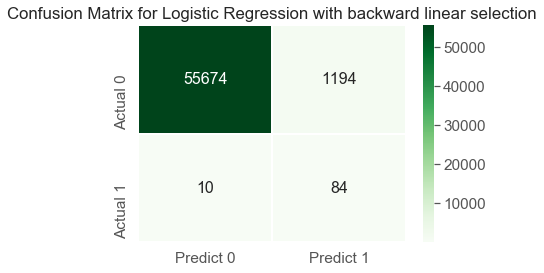

Accuracy: 0.9788631017169341
Sensitivity: 0.8936170212765957
Specificity: 0.9790040092846592
Precision: 0.06572769953051644
f1 score: 0.12244897959183673
AUC value is: 0.9766388830273617
Model classification metrics have finished calculating!
{'accuracy': 0.9788631017169341, 'sensitivity': 0.8936170212765957, 'specificity': 0.9790040092846592, 'precision': 0.06572769953051644, 'f1': 0.12244897959183673, 'auc': 0.9766388830273617, 'pr_auc': 0.6822765339665648}
Model fitting and results are complete!
Accuracy with all fraud results is 100.0%


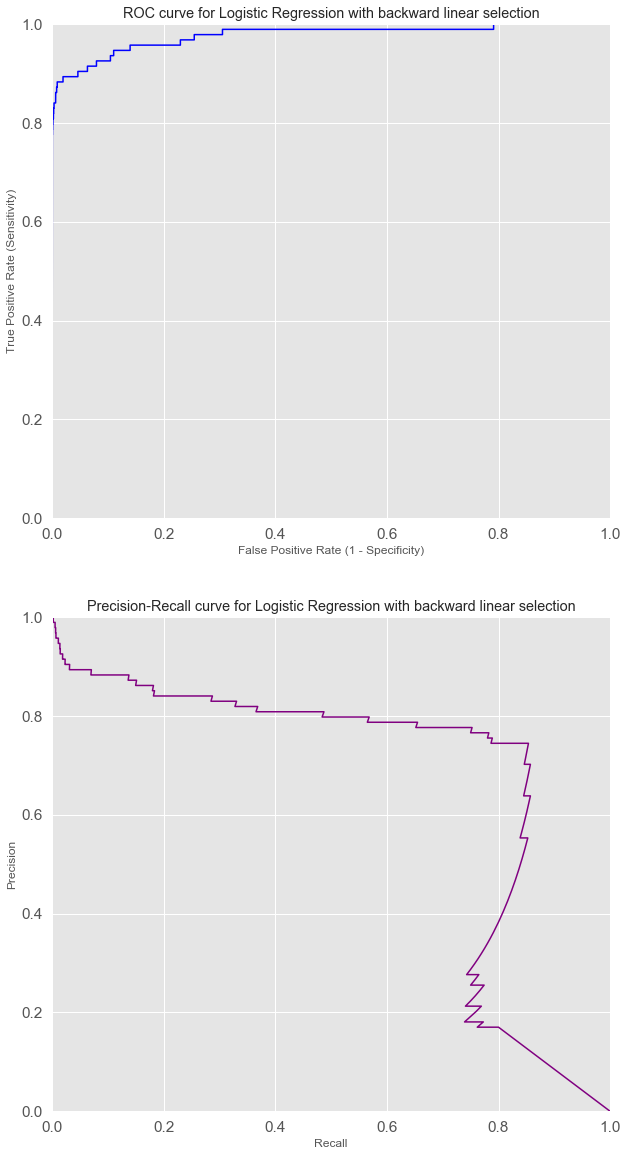

In [19]:
# finalcolstouse is list of features that are significant (p < 0.05) for logistic regression + response
# modelpipeline.run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'LogisticRegression', 'Logistic Regression with backward linear selection', False)

Oversampling is complete!
[[55698  1170]
 [   10    84]]


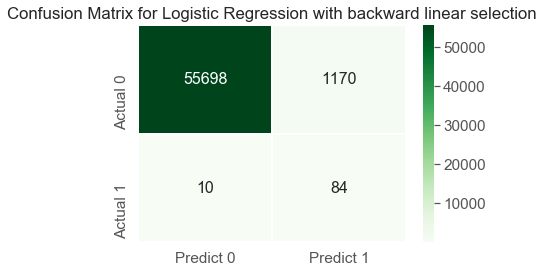

Accuracy: 0.9792844352375267
Sensitivity: 0.8936170212765957
Specificity: 0.9794260392487867
Precision: 0.06698564593301436
f1 score: 0.12462908011869436
AUC value is: 0.9768139805656698
Model classification metrics have finished calculating!
{'accuracy': 0.9792844352375267, 'sensitivity': 0.8936170212765957, 'specificity': 0.9794260392487867, 'precision': 0.06698564593301436, 'f1': 0.12462908011869436, 'auc': 0.9768139805656698, 'pr_auc': 0.6800490451604873}
Model fitting and results are complete!
Accuracy with all fraud results is 100.0%


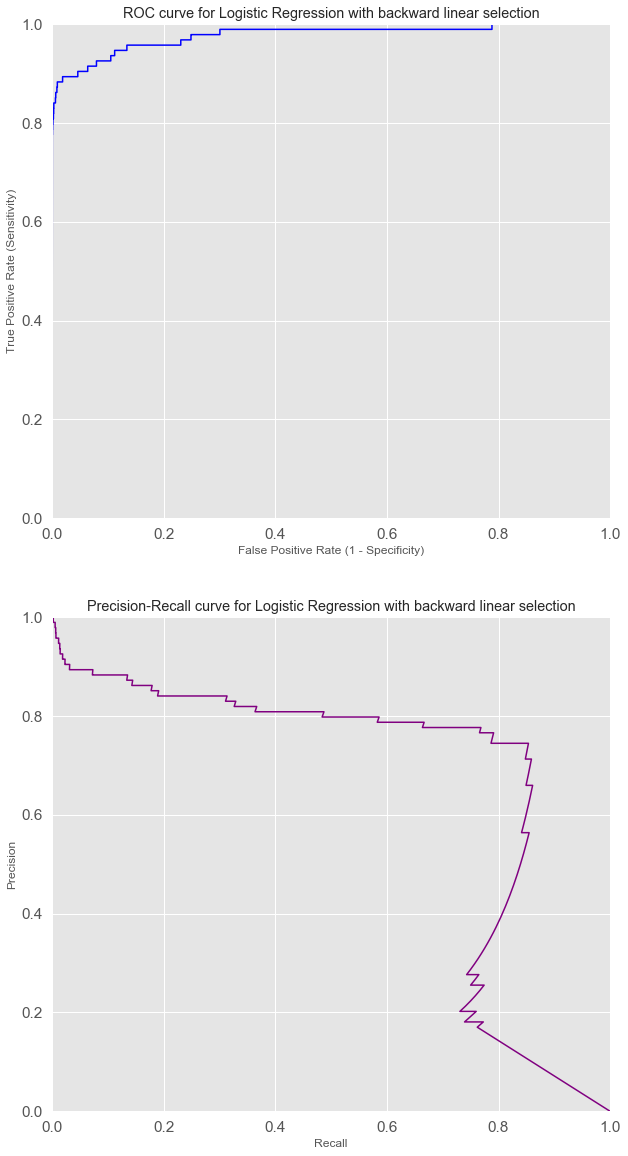

In [20]:
finalcolstouse = list(df.columns.values)
# modelpipeline.run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'LogisticRegression', 'Logistic Regression with backward linear selection', False)

# Random Forest Models without and with feature V18

In [21]:
# Based on backward selection and naive sampling, V18 was removed
finalcolstouse = list(df.columns.values)
finalcolstouse.remove('V18')
print(finalcolstouse)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


Oversampling is complete!
[[56768   100]
 [   18    76]]


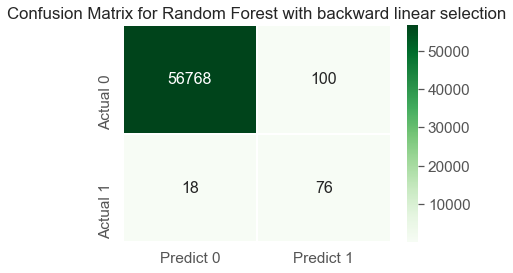

Accuracy: 0.9979284435237527
Sensitivity: 0.8085106382978723
Specificity: 0.9982415418161356
Precision: 0.4318181818181818
f1 score: 0.562962962962963
AUC value is: 0.9758707735270481
Model classification metrics have finished calculating!
{'accuracy': 0.9979284435237527, 'sensitivity': 0.8085106382978723, 'specificity': 0.9982415418161356, 'precision': 0.4318181818181818, 'f1': 0.562962962962963, 'auc': 0.9758707735270481, 'pr_auc': 0.7139050836796361}
Model fitting and results are complete!
Accuracy with all fraud results is 73.57723577235772%


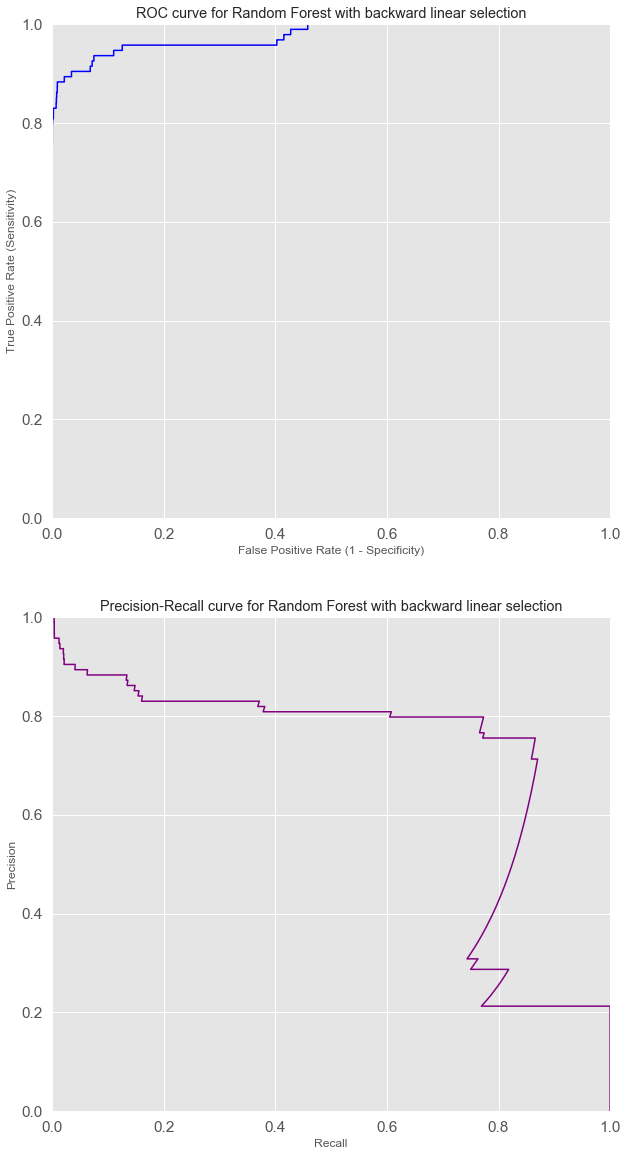

In [22]:
# finalcolstouse is list of features that are significant (p < 0.05) for logistic regression + response
# modelpipeline.run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'RandomForest', 'Random Forest with backward linear selection', False)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Oversampling is complete!
[[56773    95]
 [   18    76]]


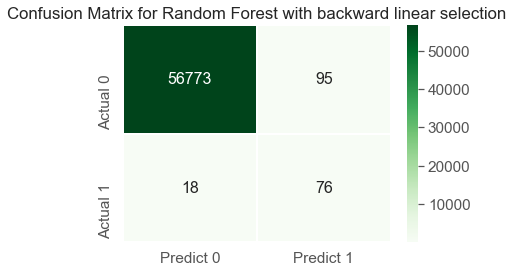

Accuracy: 0.9980162213405428
Sensitivity: 0.8085106382978723
Specificity: 0.9983294647253288
Precision: 0.4444444444444444
f1 score: 0.5735849056603773
AUC value is: 0.9767051993492957
Model classification metrics have finished calculating!
{'accuracy': 0.9980162213405428, 'sensitivity': 0.8085106382978723, 'specificity': 0.9983294647253288, 'precision': 0.4444444444444444, 'f1': 0.5735849056603773, 'auc': 0.9767051993492957, 'pr_auc': 0.6345816120820706}
Model fitting and results are complete!
Accuracy with all fraud results is 75.0%


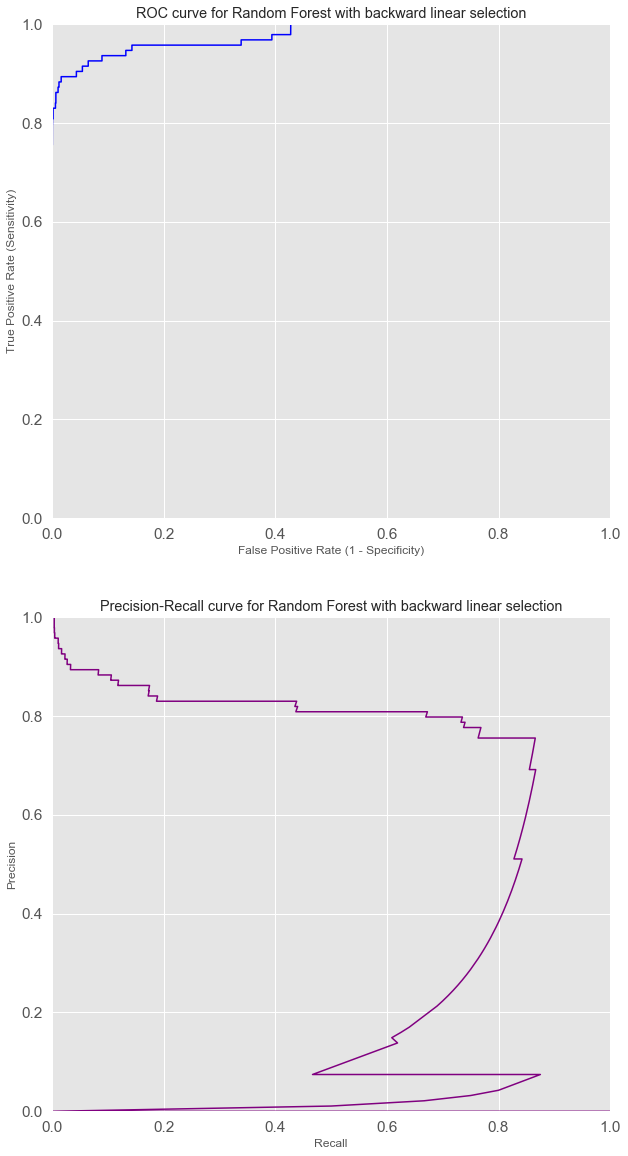

In [23]:
# Based on backward selection and naive sampling, V18 was removed
finalcolstouse = list(df.columns.values)
print(finalcolstouse)
# Compare to using all features
# run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'RandomForest', 'Random Forest with backward linear selection', False)

# XGBoost Model with and without V18 feature removed from backward selection

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Oversampling is complete!
[0]	validation_0-error:0.024964	validation_1-error:0.011025
[5]	validation_0-error:0.016786	validation_1-error:0.007321
[10]	validation_0-error:0.009457	validation_1-error:0.005003
[15]	validation_0-error:0.006377	validation_1-error:0.003652
[20]	validation_0-error:0.001139	validation_1-error:0.002949
[25]	validation_0-error:0.000864	validation_1-error:0.00244
[30]	validation_0-error:0.000662	validation_1-error:0.001931
[35]	validation_0-error:0.000534	validation_1-error:0.001668
[40]	validation_0-error:0.000446	validation_1-error:0.001492
[45]	validation_0-error:0.000396	validation_1-error:0.001369
[50]	validation_0-error:0.000336	validation_1-error:0.001317
[55]	validation_0-error:0.000299	validation_1-error:0.001194
[60]	validation_0-error:0.000273	valid

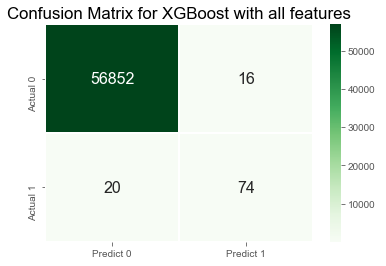

Accuracy: 0.9993679997191109
Sensitivity: 0.7872340425531915
Specificity: 0.9997186466905817
Precision: 0.8222222222222222
f1 score: 0.8043478260869565
AUC value is: 0.9819135092988766
Model classification metrics have finished calculating!
{'accuracy': 0.9993679997191109, 'sensitivity': 0.7872340425531915, 'specificity': 0.9997186466905817, 'precision': 0.8222222222222222, 'f1': 0.8043478260869565, 'auc': 0.9819135092988766, 'pr_auc': 0.7943091970136639}
Model fitting and results are complete!
Accuracy with all fraud results is 79.0650406504065%


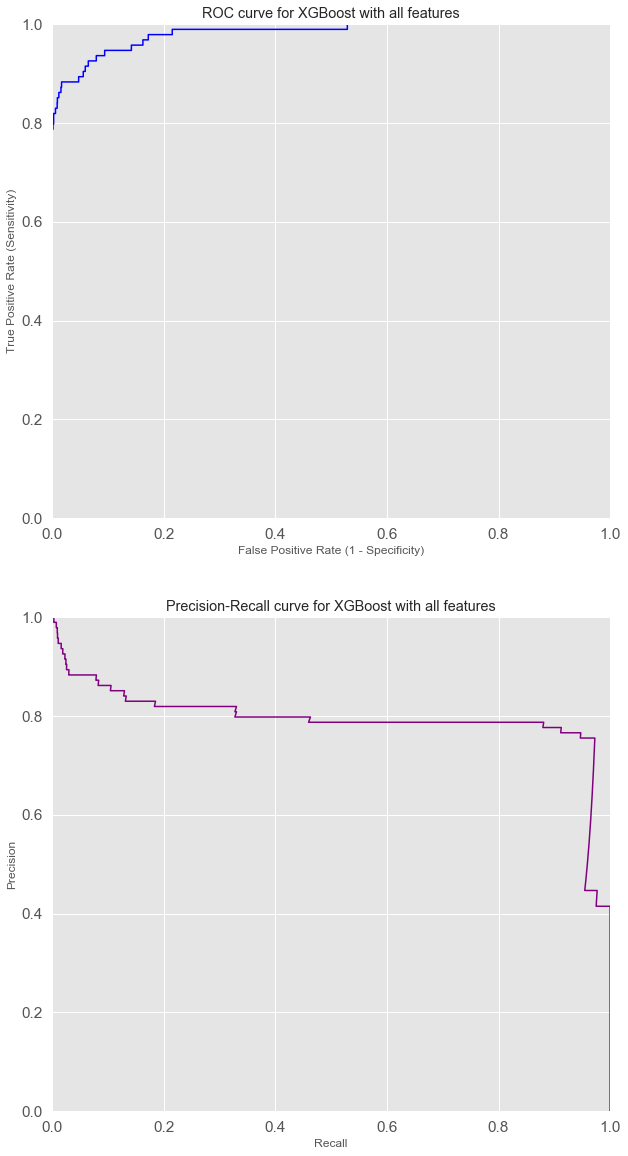

In [5]:
# Based on backward selection and naive sampling, V18 was removed
finalcolstouse = list(df.columns.values)
print(finalcolstouse)
# finalcolstouse is list of features that are significant (p < 0.05) for logistic regression + response
# run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'XGBoost', 'XGBoost with all features', False)

# Remove V18 and rebuild XGBoost

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Oversampling is complete!
[0]	validation_0-error:0.024964	validation_1-error:0.011025
[5]	validation_0-error:0.017595	validation_1-error:0.009076
[10]	validation_0-error:0.012185	validation_1-error:0.005109
[15]	validation_0-error:0.002836	validation_1-error:0.003178
[20]	validation_0-error:0.001277	validation_1-error:0.002739
[25]	validation_0-error:0.001046	validation_1-error:0.002317
[30]	validation_0-error:0.000802	validation_1-error:0.001861
[35]	validation_0-error:0.000666	validation_1-error:0.001668
[40]	validation_0-error:0.000594	validation_1-error:0.001404
[45]	validation_0-error:0.000459	validation_1-error:0.001282
[50]	validation_0-error:0.000393	validation_1-error:0.001141
[55]	validation_0-error:0.000343	validation_1-error:0.001088
[60]	validation_0-error:0.000299	validation_

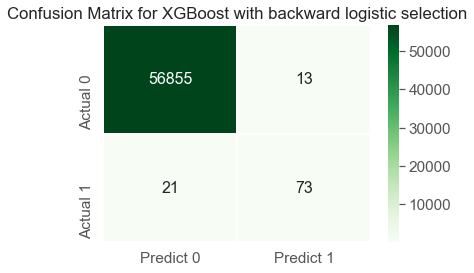

Accuracy: 0.999403110845827
Sensitivity: 0.776595744680851
Specificity: 0.9997714004360976
Precision: 0.8488372093023255
f1 score: 0.8111111111111111
AUC value is: 0.982341899643669
Model classification metrics have finished calculating!
{'accuracy': 0.999403110845827, 'sensitivity': 0.776595744680851, 'specificity': 0.9997714004360976, 'precision': 0.8488372093023255, 'f1': 0.8111111111111111, 'auc': 0.982341899643669, 'pr_auc': 0.7894768640900444}
Model fitting and results are complete!
Accuracy with all fraud results is 78.86178861788618%


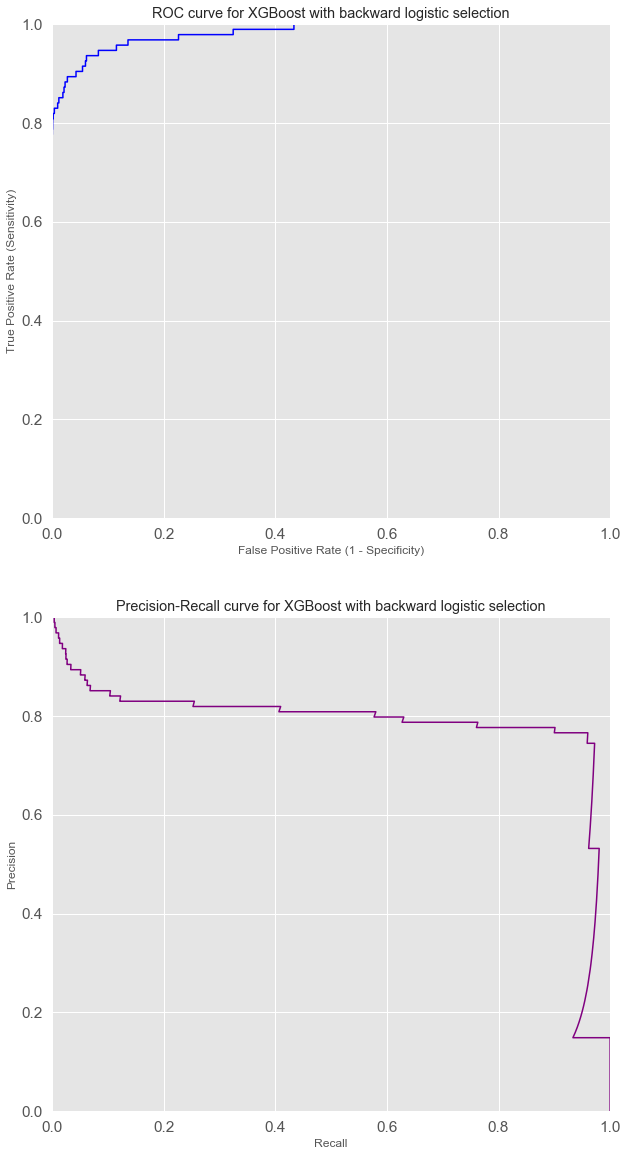

In [6]:
# Based on backward selection and naive sampling, V18 was removed
finalcolstouse = list(df.columns.values)
finalcolstouse.remove('V18')
print(finalcolstouse)
# run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'XGBoost', 'XGBoost with backward logistic selection', False)